# Pipeline for Processing GeneLab Amplicon Sequencing Data

> **The 3 Amplicon Seq Jupyter Notebook (JNs) are designed for processing samples derived from the feces of mice that were either flown in space aboard the International Space Station (ISS) (spaceflight, FLT, animals) or kept in an environmental simulator on Earth to serve as ground controls (GC, animals) during NASA's Rodent Research - 6 mission. More information about the samples analyzed here can be found in the [Open Science Data Repository (OSDR)](https://osdr.nasa.gov/bio/repo/) under [OSD-249](https://osdr.nasa.gov/bio/repo/data/studies/OSD-249). We will be processing these samples using the [GeneLab Amplicon Sequencing Data Processing Pipeline](https://github.com/nasa/GeneLab_Data_Processing/blob/master/Amplicon/Illumina/Pipeline_GL-DPPD-7104_Versions/GL-DPPD-7104-A.md) for Illumina sequence data.**  

<br>

---

## Amplicon Pipeline Overview
> This JN will cover the pipeline steps outlined in red. 
> Note that after the Primer Removal and Quality Filtering/Trimming steps, we will return to the [Setup and QC JN](04-setup-QC.ipynb) to assess the filtered and trimmed data quality. 

<br>

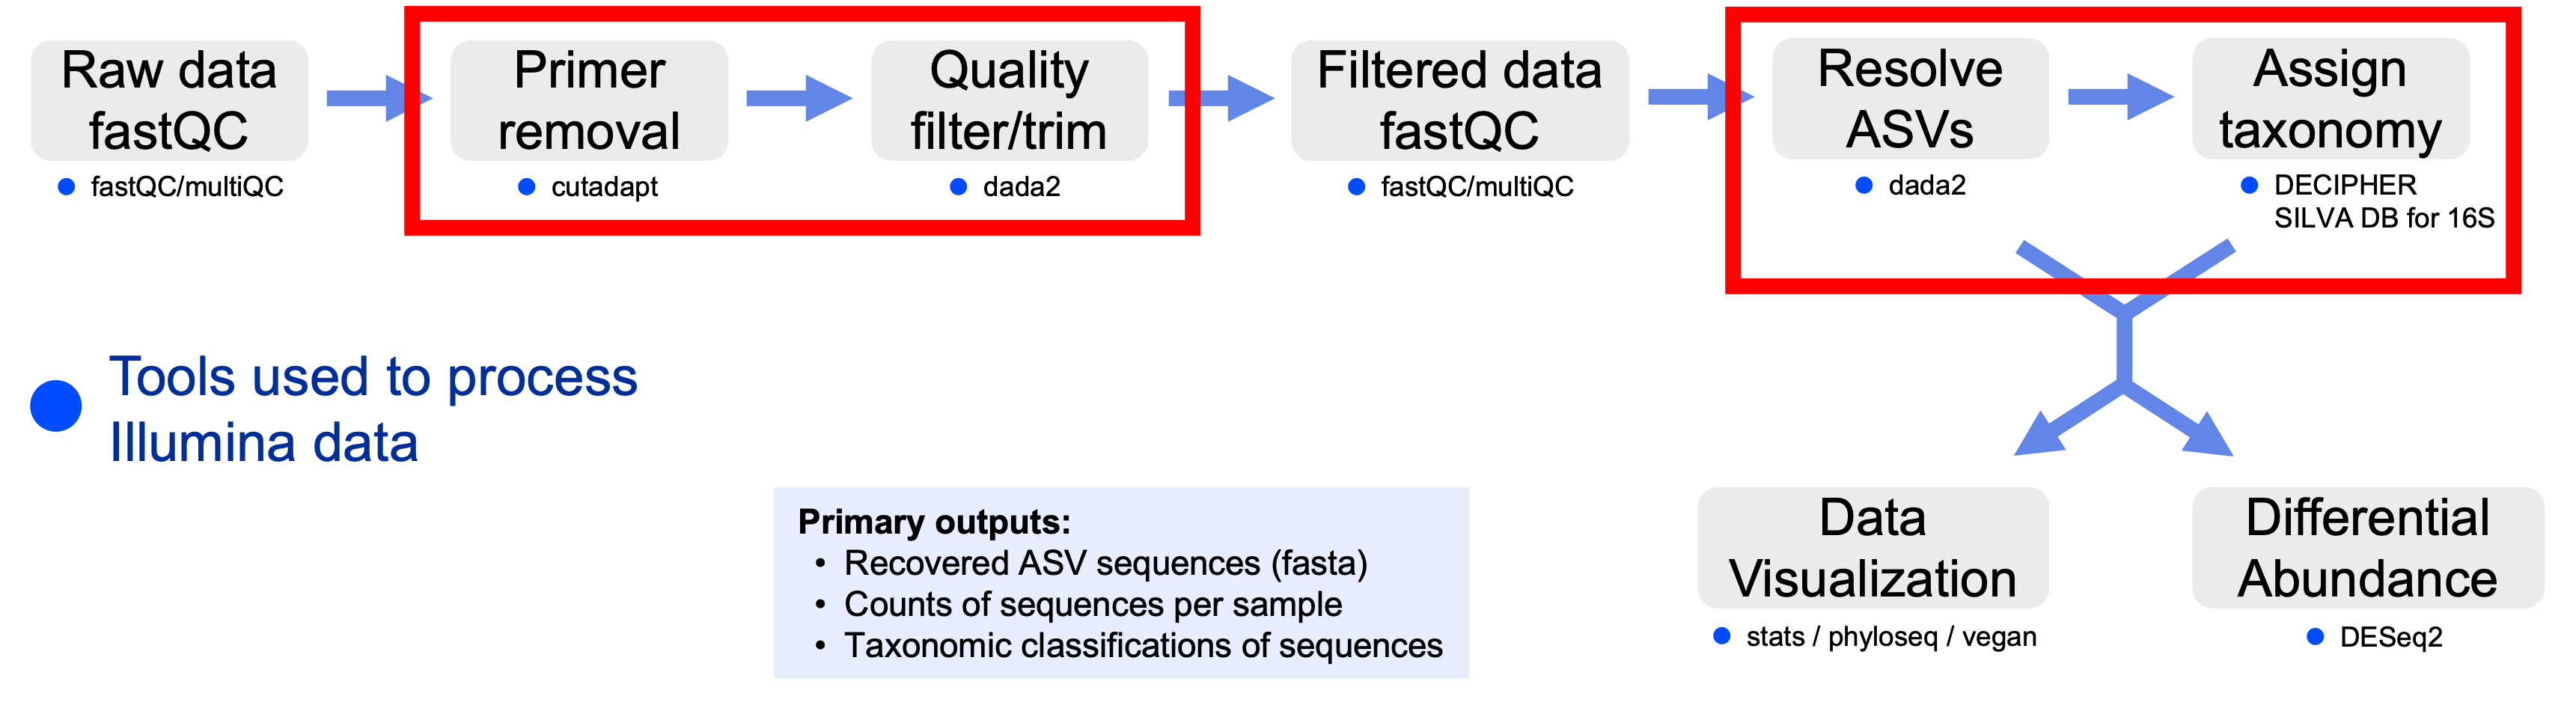

<br>

<hr style="height:0px; visibility:hidden;" />

<h1><center>2. Amplicon processing</center></h1>


<div class="alert alert-block alert-success">
Now we're ready to start getting into the actual processing! Note that we are working in an R kernel now, and while we will break down most of the code we see, don't feel like you need to digest and completely understand all of the R code right away.
</div>

---

This is notebook 2 of 3 of <a href="../00-overview.ipynb">GL4U's Amplicon Seq Bootcamp</a>. It is expected that the previous notebooks have been completed already.

---

[**Previous:** 1. Setup and QC](01-setup-QC.ipynb)
<br>

<div style="text-align: right"><a href="03-amplicon-analysis.ipynb"><b>Next:</b> 3. Amplicon analysis</a></div>

---
---

# Table of Contents

* [1. Setting up our environment](#setup)
    * [1a. Loading libraries](#loadlib)
    * [1b. Setting our location and some general variables](#loc)
    * [1c. Creating some variables to help with processing](#var)
* [2. Checking on settings to remove primers](#primercheck)
    * [2a. Ensuring we can spot the primers](#spot)
    * [2b. Doing a test trimming where we specify to cut the primers off](#test)
    * [2c. Ensuring the trimming settings successfully removed the primers](#check)
* [3. Processing with dada2](#processing-with-dada2)
    * [3a. Quality trimming/filtering (including removing primers)](#filter)
    * [3b. Generating an error model of the data](#errormod)
    * [3c. Inferring sequences](#infer)
    * [3d. Merging forward and reverse sequences](#merge)
    * [3e. Generating sequence table with counts per sample](#seqcounts)
    * [3f. Removing putative chimeras](#chimeras)
    * [3g. Generating an overview of counts throughout processing](#counts)
* [4. Assigning taxonomy](#taxonomy)
* [5. Generating and writing standard outputs](#output)

<br>

---
---

<a class="anchor" id="setup"></a>

## 1. Setting up our environment

<a class="anchor" id="loadlib"></a>

### 1a. Loading libraries

In [ ]:
library(dada2)
library(tidyverse)

<br>

<a class="anchor" id="loc"></a>

### 1b. Setting our location and some general variables

First we'll set our working directory to the GL4U-amplicon-tutorial directory that we created in our "home" directory in the [Setup and QC notebook](01-setup-QC.ipynb) and take a look at what's in there:

In [ ]:
setwd("~/GL4U-amplicon-tutorial/")

In [ ]:
list.files()

Next we'll create variables for our raw and processed data directories:

In [ ]:
raw_reads_dir <- "raw-reads"
trimmed_and_filtered_reads_dir <- "trimmed-and-filtered-reads"
fastqc_outputs_dir <- "fastqc-outputs"
final_outputs_dir <- "final-outputs"

And here we'll load our sample info and store it in a new variable (it's okay in R to have returns in the middle of code like below – it's done here to make things more easily readable and to keep the code blocks shorter width-wise):

In [ ]:
sample_info_tab <- read.table(file = "sample-info.tsv", 
                              header = TRUE, sep = "\t", 
                              row.names = 1)

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `read.table()`      - the primary function we're using
    - `file = `       - where we specify the input file we want to read
    - `header = `     - where we state if the first row should be treated as a header (TRUE/FALSE)
    - `sep = `        - where we specify the delimiter that separates values ("\t" is for tab)
    - `row.names = `  - where we can tell it if any columns should be treated as row names, this says to use the first column

</div>

Let's take a look at the sample info we read in and use it to create a variable holding a list of our sample names using the `rownames()` function, which will access the row names from a data frame:

In [ ]:
sample_info_tab

In [ ]:
sample_names <- row.names(sample_info_tab)
sample_names

<br>

<a class="anchor" id="var"></a>

### 1c. Creating some variables to help with processing

We'll start by creating two object variables, one that holds the forward raw reads files of all samples and another that holds the respective reverse raw reads files:

In [ ]:
# making an object that holds all forward raw reads files
forward_raw_files <- list.files(path = raw_reads_dir, 
                                pattern = "*R1_raw.fastq.gz", 
                                full.names = TRUE)

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `list.files()`      - the primary function we're using
    - `path = `       - the location to look for files
    - `pattern = `    - the pattern to match, here we are using the `*` wildcard to say match anything that ends with "R1_raw.fastq.gz"
    - `full.names = ` - allows us to specify if we want to retain the directory structure leading to the files, which we do want in this case (TRUE/FALSE)

</div>

Let's take a look at the object holding the forward raw reads files:

In [ ]:
forward_raw_files

Now we'll do the same for the reverse raw reads files:

In [ ]:
reverse_raw_files <- list.files(raw_reads_dir, 
                                pattern = "*R2_raw.fastq.gz", 
                                full.names = TRUE)

In [ ]:
reverse_raw_files

Next, we'll create two additional object variables, one that will hold the forward filtered/trimmed read files of all samples and another that will hold the respective reverse filtered/trimmed reads files:

In [ ]:
# making an object holding what will be the output trimmed/filtered forward reads files
forward_filtered_files <- paste0(trimmed_and_filtered_reads_dir, 
                                 "/", 
                                 sample_names, 
                                 "_R1_filtered.fastq.gz")

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `paste0()`      - the primary function we're using
    - `... `      - all arguments given as positional arugments, separated by commas, will be "pasted" together (here used to create a list of what will be the forward filtered/trimmed reads files)

</div>

Let's take a look at the object holding the future forward filtered/trimmed reads files:

In [ ]:
forward_filtered_files

Now we'll do the same for the reverse filtered/trimmed reads files:

In [ ]:
reverse_filtered_files <- paste0(trimmed_and_filtered_reads_dir, 
                                 "/", 
                                 sample_names, 
                                 "_R2_filtered.fastq.gz")

In [ ]:
reverse_filtered_files

<br>

---

<a class="anchor" id="primercheck"></a>

## 2. Checking on settings to remove primers

As discussed in the lecture materials, it is imperative that we properly remove the primers otherwise we will end up with non-biological sequences introduced due to the amibugous bases in the primers that were used. We can try trimming the primers with [dada2's quality trimming/filtering program](https://rdrr.io/bioc/dada2/man/filterAndTrim.html). But before we run it on everything, we're going to closely look at and test things on one sample – looking at the sequences before and after so we can visibly check that the primers are indeed being removed.

These are the primers for this dataset, and the utilized [IUPAC degenerate-base codes](https://www.bioinformatics.org/sms/iupac.html):

```
f primer: GTGYCAGCMGCCGCGGTAA
r primer: GGACTACNVGGGTWTCTAAT

Y = C/T  
M = A/C  
N = A/T/G/C  
V = A/C/G  
W = A/T  
```

This means for the forward primer sequence listed as:

> GTG**Y**CAGC**M**GCCGCGGTAA


The 'Y' in the 4th position actually represents a 'C' or a 'T', and the 'M' in the 9th position actually represents an 'A' or a 'C'. 

This is a concise way of writing that all of these permutations are used as the forward primers:


> GTG**C**CAGC**A**GCCGCGGTAA  
> GTG**T**CAGC**A**GCCGCGGTAA  
> GTG**C**CAGC**C**GCCGCGGTAA  
> GTG**T**CAGC**C**GCCGCGGTAA  


<a class="anchor" id="spot"></a>

### 2a. Ensuring we can spot the primers

First, we'll create a variable holding the forward raw reads file for the F10 sample to use for testing:

In [ ]:
fwd_test_file <- paste0(raw_reads_dir, "/F10_R1_raw.fastq.gz")

In [ ]:
fwd_test_file

Next we'll use the [gzcon()](https://www.rdocumentation.org/packages/base/versions/3.6.2/topics/gzcon) R function to uncompress and establish a connection with the F10_R1_raw.fastq.gz file:

In [ ]:
incon <- gzcon(file(fwd_test_file, open = "r"))

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `gzcon()`    - the primary function we're using, which let's us establish a connection with a gzip-compressed file (which is what our read files are)
    - `file()`   - another function we are "nesting" inside the `gzcon()` function; this function creates the connection to the file that we are then passing to the `gzcon()` function
        - the first positional argument ("fwd_test_file" here) is the path to the file
        - `open =` - here is where we specify the "mode" of the connection, where "r" is for "read"

</div>


For testing, we only need to look at the first couple of reads. 

**Thinking back to when we covered the fastq format:**

1. How many lines of a fastq file make up one read? 

2. Knowing that answer, how many lines of the F10_R1_raw.fastq.gz file do we need to ensure we have the first 2 reads?

<div class="alert alert-block alert-success">

<details>
<summary><b>Solutions</b></summary>

<br>

<b>1.</b> Fastq format by definition has 4 lines per entry.<br>

<b>2.</b> We would need 8 lines to hold the first two reads.
    
</details>
</div>

Here we'll create a variable that holds just the first 2 reads of the "F10_R1_raw.fastq.gz" file:

In [ ]:
fwd_lines <- readLines(con = incon, n = 8)

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `readLines()`    - the primary function we're using, which will read lines from a connected file
    - `con = `   - where we specify the connected file (here stored in our object "incon")
    - `n = ` - where we can specify how many lines we want to read

</div>

This object holds all 4 lines for both reads right now, but for what we're doing right now, we only need to see the lines that hold the sequences for each.

**Challenge:** Add a code block below to view the `fwd_lines` variable we created, and then identify which lines should be printed to only see the sequence of each read. 

<div class="alert alert-block alert-success">

<details>
<summary><b>Solution</b></summary>

<br>

We can add a new cell by selecting the cell above where we want the new one, and then clicking the "Plus" icon in the toolbar near the top of the page.
    
Then when we run just the object, `fwd_lines`, in the new cell, it prints out all 8 lines, and we can see the sequences are lines 2 and 6.
    
</details>
</div>

We learned a little about subsetting with brackets `[]` in our R intro, here we are going to use those subsetting brackets to print out just the sequences. 

If we wanted to just do one of them, say line 2, we can do it like this:

In [ ]:
fwd_lines[2]

But if we want to specify more than one line, and they're discontinuous, we need to wrap the ones we want in the `c()` function (for **c**ombine), like so:

In [ ]:
fwd_lines[c(2,6)]

**Challenge:** Why do you think we need to provide that as `fwd_lines[c(2,6)]` instead of just putting `fwd_lines[2,6]`?

<div class="alert alert-block alert-success">

<details>
<summary><b>Solution</b></summary>

<br>

If we have 2 separate arguments in the subsetting brackets, like `[2,6]`, this would be telling R how to subset in 2 dimensions. This is suitable when we have a two-dimensional object like a table, where the value before the comma is for rows and the value after is for columns. 

When we are working with a one-dimensional object, like the `fwd_lines` object is here, we can only give one argument to the subsetting brackets. So by providing `[c(2,6)]`, we are appropriately telling R it should only be operating on one dimension (like our list of lines here), but to look for the multiple things we specified in that one argument.
    
</details>
</div>

As a reminder, this is the forward primer for this dataset:

```
f primer: GTGYCAGCMGCCGCGGTAA
```

Let's print our two lines again:

In [ ]:
fwd_lines[c(2,6)]

**Look at these two sequences and answer the following question:** 

1. Can you determine where the forward-primer sequence is located in each sequence?

<div class="alert alert-block alert-success">

<details>
<summary><b>Solution</b></summary>

<br>

For each, the forward primer sequence starts right at the beginning. 

</details>
</div>


This isn't always the case, it depends on how the sequencing was done and if the data has undergone any processing already, but here our forward primer sequences start right at the front. 

The asterisks below are over the degenerate bases below. Note that the two reads we looked at differ at the position where the primer has an "M":

```
                           *    *
forward primer:         GTGYCAGCMGCCGCGGTAA
forward read 1 start:   GTGCCAGCAGCCGCGGTAA
forward read 2 start:   GTGCCAGCCGCCGCGGTAA
```

Now let's look at a couple of the sequences from the reverse raw reads for sample F10 using the same series of commands that we used to view the forward raw read sequences:

In [ ]:
rev_test_file <- paste0(raw_reads_dir, "/F10_R2_raw.fastq.gz")
rev_test_file

In [ ]:
# establishing a connection with the F10_R2_raw.fastq.gz file
incon <- gzcon(file(rev_test_file, open = "r"))

# storing the first 8 lines (or first 2 reads) in a variable
rev_lines <- readLines(incon, 8)

In [ ]:
# looking at the first 2 sequences from the first 2 reverse raw reads of sample F10
rev_lines[c(2,6)]

These also each start exactly with the reverse primer sequence right up front (the asterisks below are over the degenerate bases):

```
                                **    *
reverse primer:          GGACTACNVGGGTWTCTAAT
reverse read 1 start:    GGACTACTAGGGTTTCTAAT
reverse read 2 start:    GGACTACCCGGGTTTCTAAT
```

<br>

<a class="anchor" id="test"></a>

### 2b. Doing a test trimming where we specify to cut the primers off
The forward primer is 19 bases and the reverse is 20. We can pass these values to the `trimLeft` argument of dada2's `filterAndTrim()` function:

In [ ]:
filterAndTrim(fwd = fwd_test_file, 
              rev = rev_test_file, 
              filt = "test-F10_R1_filtered.fastq.gz",
              filt.rev = "test-F10_R2_filtered.fastq.gz", 
              trimLeft = c(19, 20))

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `filterAndTrim()` - primary function
    - `fwd = `      - where we provide the object holding all the forward raw reads input file(s)
    - `rev = `      - where we provide the object holding all the reverse raw reads input file(s)
    - `filt = `     - where we provide the object holding what will be the output forward trimmed read file(s)
    - `filt.rev = ` - where we provide the object holding what will be the output reverse trimmed read file(s)
    - `trimLeft = ` - how many bases we want to have trimmed off the left side (5' end) of the reads (Note: providing them as a vector like in the command above with two numbers means the first will be used for the forward raw reads and the second for the reverse raw reads)

</div>


Let's list all files in our current directory to see if our two trimmed reads test files were created:

In [ ]:
list.files()

<br>

<a class="anchor" id="check"></a>

### 2c. Ensuring the trimming settings successfully removed the primers
Now we are going to peek at the output trimmed reads files to make sure we cut off the primers. To do this we'll use the same approach as we did in [Step 2a](#spot), read in part of the file and then just look at the sequences of the first 2 forward and reverse trimmed reads. 

Note that here, some of the commands that were run above have been condensed into just one line using the pipe (`%>%`) operator we learned about in the R introduction:

In [ ]:
# establishing a connection and storing the first 8 lines (or first 2 reads) into a variable
fwd_filt_lines <- gzcon(file("test-F10_R1_filtered.fastq.gz", open = "r")) %>% readLines(n = 8)

And now let's look at the first 2 sequences:

In [ ]:
fwd_filt_lines[c(2,6)]

These previously started with the following:

```
                            *    *
forward primer:          GTGYCAGCMGCCGCGGTAA
original fwd read 1:     GTGCCAGCAGCCGCGGTAA   TACGGAGGAT
original fwd read 2:     GTGCCAGCCGCCGCGGTAA   TACGTAGGGG
```

**Looking at the two read sequences printed out above:** 

1. Have the forward-primer sequences been removed from both reads?


<div class="alert alert-block alert-success">

<details>
<summary><b>Solution</b></summary>

<br>

Yes, they each now begin right after where the forward-primer sequence ended 👍

</details>
</div>

Next, we'll take a look at the sequences of the first 2 trimmed reverse reads:

In [ ]:
rev_filt_lines <- gzcon(file("test-F10_R2_filtered.fastq.gz", open = "rb")) %>% readLines(8)

In [ ]:
rev_filt_lines[c(2,6)]

These ones previously started with the following:

```
                                **    *
reverse primer:          GGACTACNVGGGTWTCTAAT
original rev read 1:     GGACTACTAGGGTTTCTAAT  CCTGTTTGAT
original rev read 2:     GGACTACCCGGGTTTCTAAT  CCTTTTTGCT
```


**Looking at the two read sequences printed out above:** 

1. Have the reverse-primer sequences been removed from both reads?  


<div class="alert alert-block alert-success">

<details>
<summary><b>Solution</b></summary>

<br>

Yes, they each now begin right after where the reverse-primer sequence ended 👍

</details>
</div>




So with that confirmation (or looking at some more samples if wanted), we can be fairly confident in using the same `trimLeft` argument to remove the primers for all of our samples (since these were all prepared the same way and sequenced together).

Since we don't need the test trimmed output files anymore, let's remove them:

In [ ]:
file.remove("test-F10_R1_filtered.fastq.gz", "test-F10_R2_filtered.fastq.gz")

Use the code block below to list all files in your current directory and check to make sure the two test files have indeed been deleted:

<div class="alert alert-block alert-success">

<details>
<summary><b>Solution</b></summary>

<br>

`list.files()`

</details>
</div>

---

<a class="anchor" id="processing-with-dada2"></a>

## 3. Processing with dada2

It can help to try to keep a bird's-eye view of things, so here is an overview of the main processing steps we'll be performing:


| Function | Purpose | 
|:---:| --- |
| `filterAndTrim()` | remove primers and qualty filter/trim reads |
| `learnErrors()` | generate an error model of our data | 
| `dada()` | infer ASVs (**A**mplicon **S**equence **V**ariants) on forward and reverse reads |
| `mergePairs()` | merge forward and reverse ASVs to reconstruct full target amplicons |
| `makeSequenceTable()` | generate a count table of how many times each ASV shows up in each sample |
| `removeBimeraDenovo()` | screen for and remove putative chimeras |
| `IdTaxa()` | assign taxonomy to our ASVs |


<a class="anchor" id="filter"></a>

### 3a. Quality trimming/filtering (including removing primers)

In [ ]:
filtered_out <- filterAndTrim(fwd = forward_raw_files, 
                              rev = reverse_raw_files, 
                              filt = forward_filtered_files, 
                              filt.rev = reverse_filtered_files, 
                              trimLeft = c(19, 20), 
                              maxEE = c(1,1),
                              multithread = 6)

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `filterAndTrim()` - primary function
    - `fwd = `      - where we provide the object holding all the forward raw reads input files
    - `rev = `      - where we provide the object holding all the reverse raw reads input files
    - `filt = `     - where we provide the object holding what will be the output forward trimmed/filtered reads files
    - `filt.rev = ` - where we provide the object holding what will be the output reverse trimmed/filtered reads files
    - `trimLeft = ` - how many bases we want to have trimmed off the left side (5' end) of the reads (Note: providing them as a vector like in the command above with two numbers means the first will be used for the forward raw reads and the second for the reverse raw reads)
    - `maxEE = `    - maximum "expected error" to allow for the forward and reverse reads (set up similar to the `trimLeft` argument; you can read more about "expected error" [here](https://www.drive5.com/usearch/manual/exp_errs.html) and in its original publication [here](https://academic.oup.com/bioinformatics/article/31/21/3476/194979))
    - `multithread = ` - where we can specify how many jobs to run in parallel

</div>

Once the `filterAndTrim()` command completes, we can check if our output trimmed/filtered reads files are where we expect them to be:

In [ ]:
list.files()

In [ ]:
list.files(trimmed_and_filtered_reads_dir)


---

**Now let's switch back to the [Setup and QC notebook](01-setup-QC.ipynb#filteredqa) to run fastqc and multiqc on the trimmed/filtered reads files.**

---

<a class="anchor" id="errormod"></a>

### 3b. Generating an error model of the data

Now we are going to generate an error model by learning the specific error-signatures of our dataset. Each sequencing run, even when all goes well, will have its own subtle variations to its error profile. [dada2's learnErrors() function](https://rdrr.io/bioc/dada2/man/learnErrors.html) attempts to learn and incorporate this information when it later tries to infer the true, starting biological sequences. 

In the code block below, we will run the `learnErrors()` function on both the forward and reverse reads:

In [ ]:
err_forward_reads <- learnErrors(fls = forward_filtered_files, multithread = 6)
err_reverse_reads <- learnErrors(fls = reverse_filtered_files, multithread = 6)

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `learnErrors()` - primary function
    - `fls = `          - where we provide the object holding all the input trimmed/filtered reads files
    - `multithread = `  - where we can specify how many jobs to run in parallel

</div>

<a class="anchor" id="infer"></a>

### 3c. Inferring sequences

Here’s where dada2 gets to do what it was born to do, which is to do its best to infer true biological sequences. It does this by incorporating the error models we generated above, quality information about the reads, and abundances of each unique sequence, and then making decisions about if each sequence is more likely to be of biological origin or more likely to have been introduced by sequencing error. You can read more about the details of this in the [dada2 paper](https://www.nature.com/articles/nmeth.3869#methods) or by looking through their [site](https://benjjneb.github.io/dada2/index.html).

This step can be run on individual samples, which is the least computationally intensive manner, or on all samples together, which increases the function’s ability to resolve low-abundance ASVs (**A**mplicon **S**equence **V**ariants). 

For instance, imagine Sample A has 10,000 copies of sequence Z, and Sample B has 1 copy of sequence Z. Sequence Z would likely be filtered out of Sample B even though it was a “true” singleton (only appeared once) in Sample B among perhaps thousands of spurious singletons we needed to remove. 

Because running all samples together on large datasets can become impractical computationally, the dada2 developers a method they refore to as pseudo-pooling. This approach shares some information across all samples to help try to recover more likely legitimate low-abundance ASVs, and is explained in more detail [on their site here](https://benjjneb.github.io/dada2/pseudo.html). 

We will be using the pseudo-pooling method here:

In [ ]:
forward_seqs <- dada(derep = forward_filtered_files, 
                     err = err_forward_reads, 
                     pool = "pseudo", multithread = 6)

reverse_seqs <- dada(derep = reverse_filtered_files, 
                     err = err_reverse_reads, 
                     pool = "pseudo", multithread = 6)

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `dada()` - primary function
    - `derep = ` - where we provide the object holding all the input trimmed/filtered reads files
    - `err = `   - where we provide the object created by the `learnErrors()` function we ran in [Step 3b](#errormod) above
    - `pool = `  - where we tell it the method to use (if any) to try to pool information across samples, as explained on [this page](https://benjjneb.github.io/dada2/pseudo.html#Pseudo-pooling)
    - `multithread = `  - where we can specify how many jobs to run in parallel

</div>

<a class="anchor" id="merge"></a>

### 3d. Merging forward and reverse sequences

Now we'll use the [dada2 mergePairs()](https://rdrr.io/bioc/dada2/man/mergePairs.html) function to merge the forward and reverse ASVs to reconstruct our full target amplicons. By default, this function requires the overlapping region to be identical between the sequences being merged:

In [ ]:
merged_amplicons <- mergePairs(dadaF = forward_seqs, derepF = forward_filtered_files, 
                               dadaR = reverse_seqs, derepR = reverse_filtered_files)

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `mergePairs()` - primary function
    - `dadaF = ` - where we provide the forward read object from the `dada()` function we ran in [Step 3c](#infer) above
    - `derepF = ` - where we provide the object holding all the input forward trimmed/filtered reads files
    - `dadaR = ` - where we provide the reverse read object from the `dada()` function we ran in [Step 3c](#infer) above
    - `derepR = ` - where we provide the object holding all the input reverse trimmed/filtered reads files

</div>

<a class="anchor" id="seqcounts"></a>

### 3e. Generating sequence table with counts per sample

Now we're ready to generate a count table using the [dada2 makeSequenceTable()](https://rdrr.io/bioc/dada2/man/makeSequenceTable.html) function. This is one of the main outputs from processing an amplicon dataset. It is also often referred to as a biome table, or an OTU (**O**perational **T**axonomic **U**nit) matrix.

In [ ]:
seqtab <- makeSequenceTable(merged_amplicons)

This table isn't very friendly to look at yet, because it uses the full sequences as column names, but we can still take a peek at it with `head()`:

In [ ]:
head(seqtab)

dada2 just puts the forward read file as the sample name, which make up the row names here. And each column represents a recovered sequence. If we scroll to the right a bit, we'll see there are counts for how many times each sequence was recovered from each sample.

And we can get its dimensions with the `dim()` function:

In [ ]:
dim(seqtab)

**Looking at the dimensions of the `seqtab` table:** 

1. Which value is the number columns, and what does that number indicate?

<div class="alert alert-block alert-success">

<details>
<summary><b>Solution</b></summary>

<br>

The second value reported from `dim()` is the number of columns. Here that indicates how many unique sequences were recovered across all the samples. 

</details>
</div>

We'll make a more traditional count table that is easier to read in a few steps.

<a class="anchor" id="chimeras"></a>

### 3f. Removing putative chimeras

Chimeras are technical artifacts made during PCR where different sequences merge together to form a new sequence, and this problem is extremely common during the generation of amplicon data. The [dada2 removeBimeraDenovo() function](https://rdrr.io/bioc/dada2/man/removeBimeraDenovo.html) identifies likely chimeras by aligning each sequence with those that were recovered in greater abundance and then seeing if there are any lower-abundance sequences that can be made exactly by mixing left and right portions of two of the more-abundant ones. If so, these likely chimeric sequences are removed.

Here is how we can use the `removeBimeraDenovo()` function to remove putative chimeras from our data:

In [ ]:
seqtab.nochim <- removeBimeraDenovo(unqs = seqtab, multithread = 6)

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `removeBimeraDenovo()` - primary function
    - `unqs = ` - where we provide the object we created with the `makeSequenceTable()` function in [Step 3e](#seqcounts) above
    - `multithread = `  - where we can specify how many jobs to run in parallel

</div>

This is the same type of object as the `seqtab` we looked at above, only now where the columns are the unique AVSs that were retained after chimera removal: 

In [ ]:
head(seqtab.nochim)

Recall the number of unique sequences we had prior to chimera removal by looking at the number of columns in the `seqtab` object we made in [Step 3e](#seqcounts) above with the `makeSequenceTable()` function, which we can see by using the `ncol()` function to just count the number of columns:

In [ ]:
ncol(seqtab)

Let's see how many unique sequences we retained have after removing likely chimeras by running the same on the `seqtab.nochime` object:

In [ ]:
ncol(seqtab.nochim)

**Challenge:** Use the code block below to try to calculate the percent of unique sequences retained:

<div class="alert alert-block alert-success">

<details>
<summary><b>Solution</b></summary>

<br>

Here is one way:
    
`ncol(seqtab.nochim) / ncol(seqtab) * 100`

</details>
</div>

This tells us we dropped quite a bit in terms of the number of unique sequences recovered since we're only retaining ~17% of them. But this is not the same as the number of actual total sequences that were retained after removing likely chimeras, because many of the total sequences are seen more than once. Let's take a look at that value.

We can get the sum of all values in a table by applying the `sum()` function to it, e.g., here is how we can see how many total sequences we had prior to chimera removal:

In [ ]:
sum(seqtab)

**Challenge:** Use the code block below to calculate the percent of total sequences that were retained after chimera removal:

(*Hint: Divide the sum of all values in the `seqtab.nochim` object by the sum of all values in the `seqtab` object, then multiple that value by 100.)*

<div class="alert alert-block alert-success">

<details>
<summary><b>Solution</b></summary>

<br>

Here is one way:
    
`sum(seqtab.nochim) / sum(seqtab) * 100`

</details>
</div>

**Use the answers to the challenges above to answer the following questions:** 

1. What percent of unique (merged) sequences did we retain after removing likely chimeras?
2. What percent of total sequences did we retain after removing likely chimeras?

<div class="alert alert-block alert-success">

<details>
<summary><b>Solution</b></summary>

<br>

**1.** About 17%  
**2.** About 96%

</details>
</div>

This is a very common scenario with amplicon data, largely believed to be due to the propensity for chimeras to form during the PCR of genetic sequences with highly conserved portions.

<a class="anchor" id="counts"></a>

### 3g. Generating an overview of counts throughout processing

It can be helpful to have a count of how many reads we had at each step along the way in one table. This can aid in finding any potentially problematic steps. The developers’ [DADA2 tutorial](https://benjjneb.github.io/dada2/tutorial.html) provides an example of a nice, quick way to pull out how many reads were dropped at various steps in the pipeline. 

Here we will run a slightly modified version that also adds in a final column of percent reads retained from the start:

<div class="alert alert-block alert-info">

**Note**  
This is a very busy code block and not that straightforward for where we are at. So we aren't going to break every component down on this one. But in the future, running each part piece-by-piece and looking at what each is doing would be good practice if you want to understand it better.

</div>


In [ ]:
# making a helper function
getN <- function(x) sum(getUniques(x))

summary_tab <- data.frame(row.names = sample_names,
                          starting_read_pairs = filtered_out[, 1],
                          filtered_read_pairs = filtered_out[, 2],
                          fwd_ASVs = sapply(forward_seqs, getN),
                          rev_ASVs = sapply(reverse_seqs, getN),
                          merged_ASVs = sapply(merged_amplicons, getN),
                          non_chimeras = rowSums(seqtab.nochim),
                          final_perc_reads_retained = round(rowSums(seqtab.nochim) / filtered_out[, 1] * 100, 1)
                          )

Let's look at our summary table:

In [ ]:
summary_tab

**Use the summary table above to answer the following questions:** 

1. Roughly what percent of the starting reads were retained across samples after all steps?
2. Do you notice any differences between space-flown and ground control samples? What would it mean for group comparisons if there were any large differences? 
3. Which step(s) resulted in the greatest number of reads removed?

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

Around 83% typically.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

Not really, things look pretty consistent. If there were large differences (what counts as "large" is subjective and arbitrary), we might need to worry if those disparities might influence contrasting our groups.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q3 Solution</b></summary>

<br>

The filtering step seemed to have the most reads dropped here. This isn't always the case though. 
</details>
</div>


---

<a class="anchor" id="taxonomy"></a>

## 4. Assigning taxonomy
To assign taxonomy, we are going to use the [DECIPHER package](https://bioconductor.org/packages/release/bioc/html/DECIPHER.html), specifically hte `IdTaxa()` function described in their [paper here](https://doi.org/10.1186/s40168-018-0521-5). There are some DECIPHER-formatted databases available [here](http://www2.decipher.codes/Classification/TrainingSets/), including the SILVA_SSU_r138_2019 database that we use below. [SILVA](https://www.arb-silva.de/) is a curated database of ribosomal RNA from all 3 domains of Life.

We'll start by loading the DECIPHER library:

In [ ]:
library(DECIPHER)

Next, we'll pull the sequences out of our `seqtab.nochim` object using the [getSequences()](https://rdrr.io/bioc/dada2/man/getSequences.html) function and pass them into the [DNAStringSet()](https://rdrr.io/bioc/Biostrings/man/XStringSet-class.html) function, which creates the type of object we need:

In [ ]:
dna <- DNAStringSet(getSequences(seqtab.nochim))

Next, we'll download and load the SILVA_SSU_r138_2019 reference database from the publicly available [DECIPHER-formatted databases](http://www2.decipher.codes/Classification/TrainingSets/). As mentioned above, [SILVA](https://www.arb-silva.de/) is a curated database of ribosomal RNA from all 3 domains of Life.

In [ ]:
# downloading reference
download.file(url = "http://www2.decipher.codes/Classification/TrainingSets/SILVA_SSU_r138_2019.RData", 
              destfile = "SILVA_SSU_r138_2019.RData")

# loading reference into R
load("SILVA_SSU_r138_2019.RData")

We're now ready to classify our recovered sequences using the [DECIPHER IdTaxa()](https://rdrr.io/bioc/DECIPHER/man/IdTaxa.html) function:

In [ ]:
# classifying sequences
tax_info <- IdTaxa(test = dna, trainingSet = trainingSet, processors = 6)

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `IdTaxa()` - primary function
    - `test = ` - where we provide the dna object holding our sequences we want to classify
    - `trainingSet = ` - where we provide the object holding the reference information (it was loaded as "trainingSet" by the above `load()` function)
    - `processors = ` - where we can specify how many jobs to run in parallel

</div>


Let's take a peek at the `tax_info` object holding our classifications:

In [ ]:
tax_info

**Of the preview output taxa shown above:** 

1. Which taxa shows the highest percent confidence? Which shows the lowest? 

<div class="alert alert-block alert-success">

<details>
<summary><b>Solution</b></summary>

<br>

The first one has the highest confidence at 99%, the 81st one has the lowest of those shown at 61% confidence. There is a give and take between wanting to utilize high-confidence taxonomic assignments and wanting to classify more sequences down to a lower taxonomic level (e.g., genus instead of family). There is no single cutoff that is appropriate for, or correct in, all situations.

</details>
</div>

Below, we will use this taxonomy object to make and write out a table of taxonomy as part of our standard outputs.

---

<a class="anchor" id="output"></a>

## 5. Generating and writing standard outputs

The typical standard outputs from amplicon processing are: 
1. a fasta file of our unique ASVs 
2. a count table showing how many times each unique ASV was detected in each sample
3. and a taxonomy table linking our ASV IDs to their assigned taxonomy

Here we will show one way we can generate each of those files from the objects we've created in R.

<div class="alert alert-block alert-info">

**Note**  
The code blocks below can get a little busy, and are beyond our current scope to dig into in detail. So like above, we are not going to break every component down, but running each part piece-by-piece and looking at what it's doing would be good practice in the future if you want to understand things better.
</div>

**1. Making and writing out a fasta file of our recovered ASV sequences**

In [ ]:
# pulling out sequences
asv_seqs <- colnames(seqtab.nochim)

# giving sequences more manageable names
asv_headers <- vector(dim(seqtab.nochim)[2], mode = "character")

for (i in 1:dim(seqtab.nochim)[2]) {
    asv_headers[i] <- paste(">ASV", i, sep = "_")
}

# making an object holding our ASV IDs and sequences
asv_fasta <- c(rbind(asv_headers, asv_seqs))

# writing out as a fasta file holding our final ASV sequences
write(asv_fasta, paste0(final_outputs_dir, "/ASVs.fasta"))

Let's take a look at the first few lines of the `asv_fasta` object we created:

In [ ]:
head(asv_fasta)

<br>

**2. Making and writing out a count table of how many times each ASV was detected in each sample**

In [ ]:
# transposing the table so that columns are samples and ASVs are rows
asv_starting_tab <- t(seqtab.nochim)

# setting the column names to be our sample names
colnames(asv_starting_tab) <- sample_names

# creating an object of ASV IDs 
asv_ids <- sub(">", "", asv_headers)

# combining into a data frame with the ASV IDs
count_tab <- data.frame("ASV_ID" = asv_ids, asv_starting_tab, 
                        check.names = FALSE, row.names = NULL)

# writing out as a tab-delimited table
write.table(count_tab, paste0(final_outputs_dir, "/ASV_counts.tsv"), 
            sep = "\t", quote = FALSE, row.names = FALSE)

Let's take a look at the first few lines of the `count_tab` object we created:

In [ ]:
head(count_tab)

<br>

**3. Making and writing out a table of taxonomy**

In [ ]:
# making a vector of taxonomic ranks
ranks <- c("domain", "phylum", "class", "order", "family", "genus", "species")

# formatting the tax_info object into a new table object
starting_tax_tab <- t(sapply(tax_info, function(x) {
    m <- match(ranks, x$rank)
    taxa <- x$taxon[m]
    taxa[startsWith(taxa, "unclassified_")] <- NA
    taxa
}))

# setting the column names to be the taxonomic ranks
colnames(starting_tax_tab) <- ranks

# combining into a data frame with the ASV IDs
tax_tab <- data.frame("ASV_ID" = asv_ids, starting_tax_tab, row.names = NULL)

# writing out as a tab-delimited table
write.table(tax_tab, paste0(final_outputs_dir, "/ASV_taxonomy.tsv"), 
            sep = "\t", quote = FALSE, row.names = FALSE)

And here let's look at the first few lines of the `tax_tab` object we created:

In [ ]:
head(tax_tab)

<div class="alert alert-block alert-info">

**Note**  
Species-level classification isn't performed because it is often unreliable with just a portion of the commonly used small-subunit (SSU) rRNA gene (16S in bacteria/archaea and 18S in eukarya). Indeed, even the full-length SSU rRNA gene is sometimes not able to delineate between species (e.g., [here](https://doi.org/10.1038/s41598-017-11363-1) and [here](https://doi.org/10.1038/ismej.2015.237)). 

</div>

**Using the count (count_tab) and taxonomy (tax_tab) tables above, answer the following questions:** 

1. Do you notice any strong differences between the counts of ASVs for space-flight vs. ground-control samples in the first 6 ASVs that are shown by `head(count_tab)`?

2. In the preview of the tax_tab, how many different phyla are represented among the 6 ASVs shown? What about classes?

3. Which microbial family is most represented among those shown?


<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

Not really. ASVs 5 and 6 maybe have a higher average in the flight samples than in the ground samples, but the variance within both groups for each ASV is pretty high.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

There are 2 phyla and 3 classes shown.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q3 Solution</b></summary>

<br>

Lachnospiraceae is the most commong family shown.

</details>
</div>


---

And that's it for baseline processing now that we have our standard goods. **Next we'll move onto the [analysis notebook](03-amplicon-analysis.ipynb).**


---
---

[**Previous:** 1. Setup and QC](01-setup-QC.ipynb)
<br>

<div style="text-align: right"><a href="03-amplicon-analysis.ipynb"><b>Next:</b> 3. Amplicon analysis</a></div>
